In [1]:
import numpy as np
import cv2
import glob #so we can get list of a directory
import re #for extracting the numbers to sort
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:

'''Sort method so our undistorted images are in the same order as our input files'''
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

#This path is for the calibration images only
CALIBRATION_IMAGE_PATHS = sorted(glob.glob('/Users/michaelmcquade/Desktop/finalprojectRobotVision/640x480/*.bmp'),
                     key=numericalSort)

ROBOT_IMAGE_PATHS = sorted(glob.glob('/Users/michaelmcquade/Desktop/finalprojectRobotVision/iran/*.png'),
                     key=numericalSort)


def calibrate():
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    CHECKERBOARD = (8,6)
    objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
    objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    images = CALIBRATION_IMAGE_PATHS
    i = 0
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD,None)
        #print 'image_' + str(i) + ': ' + str(ret) #prints ret values for all images processed, should mostly be true
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2=cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
            cv2.imshow('img', img)
            cv2.waitKey(500)
        i = i + 1
    cv2.destroyAllWindows()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return ret, mtx, dist, rvecs, tvecs, objpoints, imgpoints

'''Call Calibration on checkerboard images, get camera's matrix '''

ret, mtx, dist, rvecs, tvecs, objpoints, imgpoints = calibrate()

mean_error = 0
for i in xrange(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) ) #total error: 0.269859557519

'''Save original mtx in case we need it'''
originalmtx = np.copy(mtx)

'''This is the division factor we need because the input images are half the size of the calibration images'''
rescalemtx = np.array([[.5, 1, .5], 
          [ 1, .5, .5],
           [ 1, 1, 1 ]])

'''Apply resize'''
mtx = mtx * rescalemtx

'''Undistort method, provided cameras intrinsic params,
saves undistorted images to undistortedPNGs directory'''
def undistort(mtx, dist):
    i = 0
    for images in ROBOT_IMAGE_PATHS:
        img = cv2.imread(images)
        h,  w = img.shape[:2]
        newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))
        # undistort
        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
        # crop the image
        x, y, w, h = roi
        dst = dst[y:y+h, x:x+w]
        DEST_PATH = 'undistortedPNGs/image_undistorted_' + str(i) + '.png'
        imgret = cv2.imwrite(DEST_PATH, dst)
        i = i + 1
'''Undistort images'''
undistort(mtx, dist)

'''Undistorted Images path'''
UNDISTORTED_IMAGE_PATHS = sorted(glob.glob('/Users/michaelmcquade/Desktop/finalprojectRobotVision/undistortedPNGs/*.png'),
                     key=numericalSort)

'''Rotate images 180 degrees, overwrites unsortedPNGs directory --- doesnt work'''
def rotate180(imagepaths):
    angle = 180
    i=0
    for fname in imagepaths:
        img = cv2.imread(fname)
        rows, cols, _ = img.shape
        M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
        dst = cv2.warpAffine(img,M,(cols,rows))
        DEST_PATH = 'undistortedPNGs/image_undistorted_' + str(i) + '.png'
        imgret = cv2.imwrite(DEST_PATH, dst)
        i = i + 1
rotate180(UNDISTORTED_IMAGE_PATHS)



total error: 0.269859557519


In [8]:
def makemask(image):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # define range of blue color in HSV
    lower_green = np.array([47,105,39])
    upper_green = np.array([84,255,255])

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image,image, mask= mask)
    return mask, res

def maskBall(image):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # define range of blue color in HSV
    lower_red = np.array([0,65,65])
    upper_red = np.array([10,255,255])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_red, upper_red)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image,image, mask= mask)
    return mask, res

'''Finds the average column of the bright red pixels 
   and stores as bearing. Stores -1 if there are no 
   bright red pixels in the image.'''
def ball_detector(imageBGR):
    detected = False
    image = cv2.cvtColor( imageBGR, cv2.COLOR_BGR2HSV)

    Sum = 0;
    Count = 0;
    # step by 5 through image
    for x in range(0, 215,5): 
        for y in range(0, 235, 5):
            # chose these by converting using cv2.cvtColor RGB code: R: 255 G: 0 B: 0
            if ( (image[x,y,0] < 20) and (image[x,y,1] > 65) and (image[x,y,2] > 65)): 
                #print ( " Found hue: " + str(image[x,y,0]) + "at " )
                Sum += y
                Count+= 1
    #print "Count: " + str(Count)
    if Count < 5: #threshold of 5 
        bearing = -1 #no x value because no yellow found
        detected = False
    else:
        bearing = Sum / Count # bearing is the avg of all x values where yellow was found
        detected = True

    return detected, bearing, Count


In [9]:
class Frames:
    listofFrames = sorted(glob.glob('/Users/michaelmcquade/Desktop/finalprojectRobotVision/undistortedPNGs/*.png'),
                     key=numericalSort)
    frame = 0 #starting frame
    @staticmethod
    def getNextFrame():
        image = cv2.imread(Frames.listofFrames[Frames.frame])
        _, maskedimage = makemask(image)
        _, ballMaskedImage = maskBall(image)
        Frames.frame = Frames.frame + 1
        return Frames.frame, image, maskedimage, ballMaskedImage
    
    @staticmethod
    def setNextFrame(number):
        Frames.frame = number
        return Frames.getFrameNum()
    
    @staticmethod
    def getFrameNum():
        return Frames.frame
    
    @staticmethod
    def hasNext():
        return Frames.frame < len(Frames.listofFrames)
    

In [13]:
#Reset Frame
Frames.setNextFrame(0)


0

In [14]:
surf = cv2.xfeatures2d.SURF_create(5000)
surf.setExtended(True)
lastBearing = 0


while(Frames.hasNext()):
    framenumber, image, maskedImage, ballMaskedImage = Frames.getNextFrame()
    detected, bearing, count = ball_detector(ballMaskedImage) # before color conversion
    if (detected) and (abs((bearing - lastBearing)) < 5) and (count > 250):
        cv2.putText(image, 'KICK!', (80,230), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 3, cv2.LINE_AA)
        print "kick at frame number: " + str(framenumber) + " with count of " + str(count)
    lastBearing = bearing
    #cvt to bgr 
    ballMaskedImage = cv2.cvtColor(ballMaskedImage, cv2.COLOR_RGB2BGR)
    
    #stack images
    maskboth = np.hstack((image,maskedImage))
    maskboth = np.hstack((maskboth, ballMaskedImage))
    
    # --- ball detection --- 
    if (detected):
        cv2.putText(maskboth, 'Ball Visible', (640,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    else:
        cv2.putText(maskboth, 'Ball Not Visible', (640,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA) 
    
    # --- begin surf ---
    gray = cv2.cvtColor(maskedImage, cv2.COLOR_BGR2GRAY)
    ballgray = cv2.cvtColor(ballMaskedImage, cv2.COLOR_BGR2GRAY)
    #blurring
    gray = cv2.GaussianBlur(gray,(5,5),0)
    ballgray = cv2.GaussianBlur(ballgray,(5,5),0)
    
    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
    corners = np.int0(corners)

    ballCorners = cv2.goodFeaturesToTrack(ballgray,25,0.01,10)
    ballCorners = np.int0(ballCorners)
    
    for i in corners:
        x,y = i.ravel()
        cv2.circle(gray,(x,y),3,255,-1)
    
    for i in ballCorners:
        x,y = i.ravel()
        cv2.circle(ballgray,(x,y),3,255,-1)
    
    kp, des = surf.detectAndCompute(gray,None)
    ballkp, balldes = surf.detectAndCompute(ballgray,None)
    gray = cv2.drawKeypoints(gray,kp,None,(255,0,0),4)
    ballgray = cv2.drawKeypoints(ballgray,ballkp,None,(255,0,0),4)
    surfboth = np.hstack((gray,ballgray))
    # Display the resulting frame
    cv2.imshow('raw, ground masked, ball masked', maskboth)
    cv2.moveWindow('raw, ground masked, ball masked', 0, 0)
    cv2.imshow('Surf', surfboth)
    cv2.moveWindow('Surf', 0, 285)
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

kick at frame number: 37 with count of 379
kick at frame number: 38 with count of 389
kick at frame number: 39 with count of 364
kick at frame number: 40 with count of 346
kick at frame number: 41 with count of 363
kick at frame number: 76 with count of 387
kick at frame number: 77 with count of 360
kick at frame number: 129 with count of 341
kick at frame number: 171 with count of 253
kick at frame number: 173 with count of 298


In [12]:
Frames.setNextFrame(0)

0

In [7]:
framenumber, image, maskedImage, ballMaskedImage = Frames.getNextFrame()

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0,255,(100,3))
# Take first frame and find corners in it
old_frame = maskedImage
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
while(1):
    framenumber, image, maskedImage, ballMaskedImage = Frames.getNextFrame()
    frame = maskedImage
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    print p1.size
    good_new = p1[st==1]
    good_old = p0[st==1]
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)
    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
cv2.destroyAllWindows()
cap.release()

NameError: global name 'makemask' is not defined

In [112]:
'''Without surf, shows three masked frames'''
'''while(Frames.hasNext()):
    _, image, maskedImage, ballMaskedImage = Frames.getNextFrame()
    ballMaskedImage = cv2.cvtColor(ballMaskedImage, cv2.COLOR_RGB2BGR)
    both = np.hstack((image,maskedImage))
    both = np.hstack((both, ballMaskedImage))
    cv2.imshow('masked frames', both)
    cv2.waitKey(100)
cv2.destroyAllWindows()'''

''' #surf before merging it into masked while loop
#surf algorithm
surf = cv2.xfeatures2d.SURF_create(5000)
surf.setExtended(True)

#frame = cv2.imread(UNDISTORTED_IMAGE_PATHS[0])
#Final Code maybe
while(Frames.hasNext()):
    _, _, frame, ballMaskedImage = Frames.getNextFrame()
    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ballgray = cv2.cvtColor(ballMaskedImage, cv2.COLOR_BGR2GRAY)
    #blurring
    gray = cv2.GaussianBlur(gray,(5,5),0)
    ballgray = cv2.GaussianBlur(ballgray,(5,5),0)
    
    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
    corners = np.int0(corners)

    ballCorners = cv2.goodFeaturesToTrack(ballgray,25,0.01,10)
    ballCorners = np.int0(ballCorners)
    
    for i in corners:
        x,y = i.ravel()
        cv2.circle(gray,(x,y),3,255,-1)
    
    for i in ballCorners:
        x,y = i.ravel()
        cv2.circle(ballgray,(x,y),3,255,-1)

    kp, des = surf.detectAndCompute(gray,None)
    ballkp, balldes = surf.detectAndCompute(ballgray,None)
    gray = cv2.drawKeypoints(gray,kp,None,(255,0,0),4)
    ballgray = cv2.drawKeypoints(ballgray,ballkp,None,(255,0,0),4)
    # Display the resulting frame
    both = np.hstack((gray,ballgray))
    cv2.imshow('Surf', both)
    cv2.waitKey(100)
cv2.destroyAllWindows()'''

" #surf before merging it into masked while loop\n#surf algorithm\nsurf = cv2.xfeatures2d.SURF_create(5000)\nsurf.setExtended(True)\n\n#frame = cv2.imread(UNDISTORTED_IMAGE_PATHS[0])\n#Final Code maybe\nwhile(Frames.hasNext()):\n    _, _, frame, ballMaskedImage = Frames.getNextFrame()\n    # Our operations on the frame come here\n    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)\n    ballgray = cv2.cvtColor(ballMaskedImage, cv2.COLOR_BGR2GRAY)\n    #blurring\n    gray = cv2.GaussianBlur(gray,(5,5),0)\n    ballgray = cv2.GaussianBlur(ballgray,(5,5),0)\n    \n    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)\n    corners = np.int0(corners)\n\n    ballCorners = cv2.goodFeaturesToTrack(ballgray,25,0.01,10)\n    ballCorners = np.int0(ballCorners)\n    \n    for i in corners:\n        x,y = i.ravel()\n        cv2.circle(gray,(x,y),3,255,-1)\n    \n    for i in ballCorners:\n        x,y = i.ravel()\n        cv2.circle(ballgray,(x,y),3,255,-1)\n\n    kp, des = surf.detectAndCompute(gray,

In [ ]:
'''working version
while(Frames.hasNext()):
    framenumber, image, maskedImage, ballMaskedImage = Frames.getNextFrame()
    detected, bearing, count = ball_detector(ballMaskedImage) # before color conversion
    if (detected) and (abs((bearing - lastBearing)) < 5) and (count > 250):
        cv2.putText(image, 'KICK!', (80,230), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 3, cv2.LINE_AA)
        print "kick at frame number: " + str(framenumber) + " with count of " + str(count)
    lastBearing = bearing
    #cvt to bgr 
    ballMaskedImage = cv2.cvtColor(ballMaskedImage, cv2.COLOR_RGB2BGR)
    
    #stack images
    maskboth = np.hstack((image,maskedImage))
    maskboth = np.hstack((maskboth, ballMaskedImage))
    
    # --- ball detection --- 
    if (detected):
        cv2.putText(maskboth, 'Ball Visible', (640,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    else:
        cv2.putText(maskboth, 'Ball Not Visible', (640,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA) 
    
    # --- begin surf ---
    gray = cv2.cvtColor(maskedImage, cv2.COLOR_BGR2GRAY)
    ballgray = cv2.cvtColor(ballMaskedImage, cv2.COLOR_BGR2GRAY)
    #blurring
    gray = cv2.GaussianBlur(gray,(5,5),0)
    ballgray = cv2.GaussianBlur(ballgray,(5,5),0)
    
    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
    corners = np.int0(corners)

    ballCorners = cv2.goodFeaturesToTrack(ballgray,25,0.01,10)
    ballCorners = np.int0(ballCorners)
    
    for i in corners:
        x,y = i.ravel()
        cv2.circle(gray,(x,y),3,255,-1)
    
    for i in ballCorners:
        x,y = i.ravel()
        cv2.circle(ballgray,(x,y),3,255,-1)
    
    kp, des = surf.detectAndCompute(gray,None)
    ballkp, balldes = surf.detectAndCompute(ballgray,None)
    gray = cv2.drawKeypoints(gray,kp,None,(255,0,0),4)
    ballgray = cv2.drawKeypoints(ballgray,ballkp,None,(255,0,0),4)
    surfboth = np.hstack((gray,ballgray))
    # Display the resulting frame
    cv2.imshow('raw, ground masked, ball masked', maskboth)
    cv2.moveWindow('raw, ground masked, ball masked', 0, 0)
    cv2.imshow('Surf', surfboth)
    cv2.moveWindow('Surf', 0, 285)
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()'''

In [12]:
surf = cv2.xfeatures2d.SURF_create(5000)
surf.setExtended(True)
lastBearing = 0

framenumber, image, maskedImage, ballMaskedImage = Frames.getNextFrame()
gray = cv2.cvtColor(maskedImage, cv2.COLOR_BGR2GRAY)
old_gray = cv2.GaussianBlur(old_gray,(5,5),0)
corners = cv2.goodFeaturesToTrack(old_gray,25,0.01,10)
corners = np.int0(corners)
old_kp, old_des = surf.detectAndCompute(old_gray,None)
while(Frames.hasNext()):
    framenumber, image, maskedImage, ballMaskedImage = Frames.getNextFrame()
    detected, bearing, count = ball_detector(ballMaskedImage) # before color conversion
    if (detected) and (abs((bearing - lastBearing)) < 5) and (count > 250):
        cv2.putText(image, 'KICK!', (80,230), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 3, cv2.LINE_AA)
        print "kick at frame number: " + str(framenumber) + " with count of " + str(count)
    lastBearing = bearing
    #cvt to bgr 
    ballMaskedImage = cv2.cvtColor(ballMaskedImage, cv2.COLOR_RGB2BGR)
    
    #stack images
    maskboth = np.hstack((image,maskedImage))
    maskboth = np.hstack((maskboth, ballMaskedImage))
    
    # --- ball detection --- 
    if (detected):
        cv2.putText(maskboth, 'Ball Visible', (640,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    else:
        cv2.putText(maskboth, 'Ball Not Visible', (640,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA) 
    
    # --- begin surf ---
    gray = cv2.cvtColor(maskedImage, cv2.COLOR_BGR2GRAY)
    ballgray = cv2.cvtColor(ballMaskedImage, cv2.COLOR_BGR2GRAY)
    #blurring
    gray = cv2.GaussianBlur(gray,(5,5),0)
    ballgray = cv2.GaussianBlur(ballgray,(5,5),0)
    
    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
    corners = np.int0(corners)

    ballCorners = cv2.goodFeaturesToTrack(ballgray,25,0.01,10)
    ballCorners = np.int0(ballCorners)
    
    for i in corners:
        x,y = i.ravel()
        cv2.circle(gray,(x,y),3,255,-1)
    
    for i in ballCorners:
        x,y = i.ravel()
        cv2.circle(ballgray,(x,y),3,255,-1)
    
    kp, des = surf.detectAndCompute(gray,None)
    ballkp, balldes = surf.detectAndCompute(ballgray,None)
    gray = cv2.drawKeypoints(gray,kp,None,(255,0,0),4)
    ballgray = cv2.drawKeypoints(ballgray,ballkp,None,(255,0,0),4)
    surfboth = np.hstack((gray,ballgray))
    # Display the resulting frame
    cv2.imshow('raw, ground masked, ball masked', maskboth)
    cv2.moveWindow('raw, ground masked, ball masked', 0, 0)
    cv2.imshow('Surf', surfboth)
    cv2.moveWindow('Surf', 0, 285)
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

IndexError: list index out of range

In [13]:

Frames.setNextFrame(0)
surf = cv2.xfeatures2d.SURF_create(5000)
surf.setExtended(True)
lastBearing = 0
orb = cv2.ORB_create()

_, image, maskedImage, ballMaskedImage = Frames.getNextFrame()

while(Frames.hasNext()):
    framenumber, image1, maskedImage1, ballMaskedImage1 = Frames.getNextFrame()
    
    #orb
    
    kp1, des1 = orb.detectAndCompute(image,None)
    kp2, des2 = orb.detectAndCompute(image1,None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors.
    matches = bf.match(des1,des2)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    # Draw first 10 matches.
    img3 = np.hstack((image, image1))
    img3 = cv2.drawMatches(image,kp1,image1,kp2,matches[:10], img3, flags=2)

    
    detected, bearing, count = ball_detector(ballMaskedImage1) # before color conversion
    if (detected) and (abs((bearing - lastBearing)) < 5) and (count > 250):
        cv2.putText(image, 'KICK!', (80,230), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 3, cv2.LINE_AA)
        print "kick at frame number: " + str(framenumber) + " with count of " + str(count)
    lastBearing = bearing
    #cvt to bgr 
    ballMaskedImage1 = cv2.cvtColor(ballMaskedImage1, cv2.COLOR_RGB2BGR)
    

    
    #stack images
    maskboth = np.hstack((image1,maskedImage1))
    maskboth = np.hstack((maskboth, ballMaskedImage1))
    
    # --- ball detection --- 
    if (detected):
        cv2.putText(maskboth, 'Ball Visible', (640,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    else:
        cv2.putText(maskboth, 'Ball Not Visible', (640,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA) 
    
    # --- begin surf ---
    gray = cv2.cvtColor(maskedImage1, cv2.COLOR_BGR2GRAY)
    ballgray = cv2.cvtColor(ballMaskedImage1, cv2.COLOR_BGR2GRAY)
    #blurring
    gray = cv2.GaussianBlur(gray,(5,5),0)
    ballgray = cv2.GaussianBlur(ballgray,(5,5),0)
    
    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
    corners = np.int0(corners)

    ballCorners = cv2.goodFeaturesToTrack(ballgray,25,0.01,10)
    ballCorners = np.int0(ballCorners)
    
    for i in corners:
        x,y = i.ravel()
        cv2.circle(gray,(x,y),3,255,-1)
    
    for i in ballCorners:
        x,y = i.ravel()
        cv2.circle(ballgray,(x,y),3,255,-1)
    
    kp, des = surf.detectAndCompute(gray,None)
    ballkp, balldes = surf.detectAndCompute(ballgray,None)
    gray = cv2.drawKeypoints(gray,kp,None,(255,0,0),4)
    ballgray = cv2.drawKeypoints(ballgray,ballkp,None,(255,0,0),4)
    surfboth = np.hstack((gray,ballgray))
    # Display the resulting frame
    cv2.imshow('raw, ground masked, ball masked', maskboth)
    cv2.moveWindow('raw, ground masked, ball masked', 0, 0)
    cv2.imshow('Surf', surfboth)
    cv2.moveWindow('Surf', 0, 285)
    cv2.imshow('Matcher', img3)
    cv2.moveWindow('Matcher',  0,550)
    image = image1
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

kick at frame number: 37 with count of 379
kick at frame number: 38 with count of 389
kick at frame number: 39 with count of 364
kick at frame number: 40 with count of 346
kick at frame number: 41 with count of 363
kick at frame number: 76 with count of 387
kick at frame number: 77 with count of 360


error: /tmp/opencv-20171112-53254-axs83r/opencv-3.3.1/modules/core/src/stat.cpp:4017: error: (-215) type == src2.type() && src1.cols == src2.cols && (type == 5 || type == 0) in function batchDistance


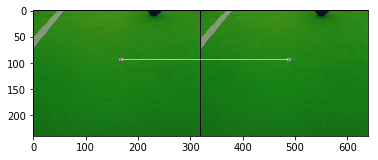

(<matplotlib.image.AxesImage at 0x117405b90>, None)

In [244]:
Frames.setNextFrame(0)
_, image, maskedImage, ballMaskedImage = Frames.getNextFrame()
_, image2, maskedImage2, ballMaskedImage2 = Frames.getNextFrame()
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(image,None)
kp2, des2 = orb.detectAndCompute(image2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = np.hstack((image, image2))
img3 = cv2.drawMatches(image,kp1,image2,kp2,matches[:10], img3, flags=2)


plt.imshow(img3),plt.show()